# Tutorial: Extracting Maximum Storage Temperatures for Transistors from PDF Datasheets

# Introduction

We will walk through the process of using `Fonduer` to extract relations from [**richly formatted** data](https://hazyresearch.github.io/snorkel/blog/fonduer.html), where information is conveyed via combinations of textual, structural, tabular, and visual expressions, as seen in webpages, business reports, product specifications, and scientific literature.

In this tutorial, we use `Fonduer` to identify mentions of the maximum storage temperature of transistors (e.g. `150°C`) in a corpus of transistor datasheets from [Digikey.com](https://www.digikey.com/products/en/discrete-semiconductor-products/transistors-bipolar-bjt-single/276).

The tutorial is broken into several parts, each covering a phase of the `Fonduer` pipeline (as outlined in the [paper](https://arxiv.org/abs/1703.05028)), and the iterative KBC process:

1. KBC Initialization
2. Candidate Generation and Multimodal Featurization
3. Probabilistic Relation Classification
4. Error Analysis and Iterative KBC

In addition, we show how users can iteratively improve labeling functions to improve relation extraction quality.

# Phase 1: KBC Initialization

In this first phase of `Fonduer`'s pipeline, `Fonduer` uses a user-specified _schema_ to initialize a relational database where the output KB will be stored. Furthermore, `Fonduer` iterates over its input _corpus_ and transforms each document into a unified data model, which captures the variability and multimodality of richly formatted data. This unified data model then servers as an intermediate representation used in the rest of the phases.

This preprocessed data is saved to a database. The connection string to the database is provided to the `Meta` object, which will initialize a PostgreSQL database for parallel execution.

We initialize several variables for convenience that define what the database should be called and what level of parallelization the `Fonduer` pipeline will be run with.

Before you continue, please make sure that you have PostgreSQL installed and have created a new database named `stg_temp_max`.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import logging

# Configure logging for Fonduer
logging.basicConfig(stream=sys.stdout, format='[%(levelname)s] %(name)s - %(message)s')
log = logging.getLogger('fonduer')
log.setLevel(logging.INFO)

PARALLEL = 4 # assuming a quad-core machine
ATTRIBUTE = "stg_temp_max"
conn_string = 'postgres://localhost:5432/' + ATTRIBUTE

## 1.1 Parsing and Transforming the Input Documents into Unified Data Models

We first initialize a `Meta` object, which manages the connection to the database automatically, and enables us to save intermediate results.

In [2]:
from fonduer import Meta

session = Meta.init(conn_string).Session()

[INFO] fonduer.meta - Validating postgres://localhost:5432/stg_temp_max as a connection string...
[INFO] fonduer.meta - Connecting user:None to localhost:5432/stg_temp_max
[INFO] fonduer.meta - Initializing the storage schema


Next, we load the corpus of datasheets and transform them into the unified data model. Each datasheet has a PDF and HTML representation (in this example, the HTML is created using Adobe Acrobat). Both representations are used in conjunction to create a robust unified data model with textual, structural, tabular, and visual modality information. Note that since each document is independent of each other, we can parse the documents in parallel. We depend on PostgreSQL for this functionality.

### Configuring an `HTMLDocPreprocessor`
We start by setting the paths to where our documents are stored, and defining a `HTMLDocPreprocessor` to read in the documents found in the specified paths. `max_docs` specified the number of documents to parse. For the sake of this tutorial, we only look at 100 documents.

**Note that you need to have run `download_data.sh` before executing these next steps or you won't have the documents needed for the tutorial.**

In [3]:
from fonduer.parser.preprocessors import HTMLDocPreprocessor
from fonduer.parser import Parser

docs_path = 'data/html/'
pdf_path = 'data/pdf/'

max_docs = 100
doc_preprocessor = HTMLDocPreprocessor(docs_path, max_docs=max_docs)

### Configuring a `Parser`
Next, we configure a `Parser`, which serves as our `CorpusParser` for PDF documents. We use [spaCy](https://spacy.io/) as a preprocessing tool to split our documents into sentences and tokens, and to provide annotations such as part-of-speech tags and dependency parse structures for these sentences. In addition, we can specify which modality information to include in the unified data model for each document. Below, we enable all modality information.

In [4]:
corpus_parser = Parser(structural=True, lingual=True, visual=True, pdf_path=pdf_path)
%time corpus_parser.apply(doc_preprocessor, parallelism=PARALLEL)

[INFO] fonduer.utils.udf - Clearing existing...
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0), HTML(value='')))


CPU times: user 17.1 s, sys: 260 ms, total: 17.4 s
Wall time: 21min 48s


We can then use simple database queries (written in the syntax of [SQLAlchemy](http://www.sqlalchemy.org/), which `Fonduer` uses) to check how many documents and sentences were parsed, or even check how many sentences are contained in each document.

In [5]:
from fonduer.parser.models import Document, Sentence

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

Documents: 100
Sentences: 46414


## 1.2 Dividing the Corpus into Test and Train

We'll split the documents 80/10/10 into train/dev/test splits. Note that here we do this in a non-random order to preverse the consistency in the tutorial, and we reference the splits by 0/1/2 respectively.

In [6]:
docs = session.query(Document).order_by(Document.name).all()
ld   = len(docs)

train_docs = set()
dev_docs   = set()
test_docs  = set()
splits = (0.8, 0.9)
data = [(doc.name, doc) for doc in docs]
data.sort(key=lambda x: x[0])
for i, (doc_name, doc) in enumerate(data):
    if i < splits[0] * ld:
        train_docs.add(doc)
    elif i < splits[1] * ld:
        dev_docs.add(doc)
    else:
        test_docs.add(doc)
from pprint import pprint
pprint([x.name for x in train_docs])

['BC546-BC548C(TO-92)',
 'DISES00189-1',
 'CSEMS03485-1',
 'CSEMS05382-1',
 'INFNS19372-1',
 'MCCCS08818-1',
 'BC547',
 'DISES00192-1',
 'MCCCS08984-1',
 'CSEMS05383-1',
 'JCSTS01155-1',
 'ONSMS04099-1',
 'CentralSemiconductorCorp_CXT4033TR',
 'DISES00242-1',
 'MCCCS09540-1',
 'CSEMS02742-1',
 'DiodesIncorporated_2DD26527',
 'KECCS03676-1',
 'NXPUSAInc_PBSS5360PASX',
 'ONSemiconductor_MMBT6521LT1',
 'DISES00490-1',
 'MCCCS09741-1',
 'DiodesIncorporated_FCX491ATA',
 'KECCS05435-1',
 'BC182-D',
 'DISES00616-1',
 'MicroCommercialCo_2N3904AP',
 'CentralSemiconductorCorp_CMPT5401ETR',
 'DiodesIncorporated_FZT651TC',
 'BC546',
 'LITES00424-1',
 'MOTOS04796-1',
 'BC337-D',
 'DISES00645-1',
 'CentralSemiconductorCorp_CENU45',
 'DiodesIncorporated_ZTX688BSTZ',
 'LITES00686-1',
 'MOTOS04676-1',
 'MicroCommercialCo_TIP29ABP',
 'BC337',
 'MicrosemiCorporation_2N2484UB',
 'CentralSemiconductorCorp_2N4013',
 'DiodesIncorporated_ZTX789ASTZ',
 'BC546A_Series_B14-521026',
 'LITES00689-1',
 'PHGLS19500-

# Phase 2: Mention Extraction, Candidate Extraction Multimodal Featurization

Given the unified data model from Phase 1, `Fonduer` extracts relation
candidates based on user-provided **matchers** and **throttlers**. Then,
`Fonduer` leverages the multimodality information captured in the unified data
model to provide multimodal features for each candidate.

## 2.1 Mention Extraction

The first step is to extract **mentions** from our corpus. A `mention` is the
type of object which makes up a `candidate`. For example, if we wanted to
extract pairs of transistor part numbers and their corresponding maximum
storage temperatures, the transistor part number would be one `mention` while
the temperature value would be another. These `mention`s are then combined to
create `candidates`, where our task is to predict which `candidates` are true
in the associated document.

We first start by defining and naming our two `mention`s:

In [7]:
from fonduer.candidates.models import mention_subclass

Part = mention_subclass("Part")
Temp = mention_subclass("Temp")

Next, we write **matchers** to define which spans of text in the corpus are
instances of each entity. Matchers can leverage a variety of information from
regular expressions, to dictionaries, to user-defined functions. Furthermore,
different techniques can be combined to form higher quality matchers. In
general, matchers should seek to be as precise as possible while maintaining
complete recall. More documentation about Matchers can be found on [Read the Docs](https://fonduer.readthedocs.io/en/stable/user/matchers.html).

In our case, we need to write a matcher that defines a transistor part number
and a matcher to define a valid temperature value.

### Writing a simple temperature matcher

Our maximum storage temperature matcher can be a very simple regular expression
since we know that we are looking for integers, and by inspecting a portion of
our corpus, we see that maximum storage temperatures fall within a fairly
narrow range.

In [8]:
from fonduer.candidates.matchers import RegexMatchSpan, DictionaryMatch, LambdaFunctionMatcher, Intersect, Union

temp_matcher = RegexMatchSpan(rgx=r"(?:[1][5-9]|20)[05]", longest_match_only=False)

### Writing an advanced transistor part matcher

In contrast, transistor part numbers are complex expressions. Here, we show how transistor part numbers can leverage [naming conventions](https://en.wikipedia.org/wiki/Transistor#Part_numbering_standards.2Fspecifications) as regular expressions, and use a dictionary of known part numbers, and use user-defined functions together. First, we create a regular expression matcher for standard transistor naming conventions.

In [9]:
### Transistor Naming Conventions as Regular Expressions ###
eeca_rgx = r'([ABC][A-Z][WXYZ]?[0-9]{3,5}(?:[A-Z]){0,5}[0-9]?[A-Z]?(?:-[A-Z0-9]{1,7})?(?:[-][A-Z0-9]{1,2})?(?:\/DG)?)'
jedec_rgx = r'(2N\d{3,4}[A-Z]{0,5}[0-9]?[A-Z]?)'
jis_rgx = r'(2S[ABCDEFGHJKMQRSTVZ]{1}[\d]{2,4})'
others_rgx = r'((?:NSVBC|SMBT|MJ|MJE|MPS|MRF|RCA|TIP|ZTX|ZT|ZXT|TIS|TIPL|DTC|MMBT|SMMBT|PZT|FZT|STD|BUV|PBSS|KSC|CXT|FCX|CMPT){1}[\d]{2,4}[A-Z]{0,5}(?:-[A-Z0-9]{0,6})?(?:[-][A-Z0-9]{0,1})?)'

part_rgx = '|'.join([eeca_rgx, jedec_rgx, jis_rgx, others_rgx])
part_rgx_matcher = RegexMatchSpan(rgx=part_rgx, longest_match_only=True)

Next, we can create a matcher from a dictionary of known part numbers:

In [10]:
import csv

def get_digikey_parts_set(path):
    """
    Reads in the digikey part dictionary and yeilds each part.
    """
    all_parts = set()
    with open(path, "r") as csvinput:
        reader = csv.reader(csvinput)
        for line in reader:
            (part, url) = line
            all_parts.add(part)
    return all_parts

### Dictionary of known transistor parts ###
dict_path = 'data/digikey_part_dictionary.csv'
part_dict_matcher = DictionaryMatch(d=get_digikey_parts_set(dict_path))

We can also use user-defined functions to further improve our matchers. For example, here we use patterns in the document filenames as a signal for whether a span of text in a document is a valid transistor part number.

In [11]:
from builtins import range

def common_prefix_length_diff(str1, str2):
    for i in range(min(len(str1), len(str2))):
        if str1[i] != str2[i]:
            return min(len(str1), len(str2)) - i
    return 0

def part_file_name_conditions(attr):
    file_name = attr.sentence.document.name
    if len(file_name.split('_')) != 2: return False
    if attr.get_span()[0] == '-': return False
    name = attr.get_span().replace('-', '')
    return any(char.isdigit() for char in name) and any(char.isalpha() for char in name) and common_prefix_length_diff(file_name.split('_')[1], name) <= 2

add_rgx = '^[A-Z0-9\-]{5,15}$'

part_file_name_lambda_matcher = LambdaFunctionMatcher(func=part_file_name_conditions)
part_file_name_matcher = Intersect(RegexMatchSpan(rgx=add_rgx, longest_match_only=True), part_file_name_lambda_matcher)

Then, we can union all of these matchers together to form our final part matcher.

In [12]:
part_matcher = Union(part_rgx_matcher, part_dict_matcher, part_file_name_matcher)

These two matchers define each entity in our relation schema.

### Define a Mention's `MentionSpace`

Next, in order to define the "space" of all mentions that are even considered
from the document, we need to define a `MentionSpace` for each component of the
relation we wish to extract. Fonduer provides a default `MentionSpace` for you
to use, but you can also extend the default `MentionSpace` depending on your
needs.

In the case of transistor part numbers, the `MentionSpace` can be quite complex
due to the need to handle implicit part numbers that are implied in text like
"BC546A/B/C...BC548A/B/C", which refers to 9 unique part numbers. To handle
these, we consider all n-grams up to 3 words long.

In contrast, the `MentionSpace` for temperature values is simpler: we only need
to process different Unicode representations of a (`-`), and don't need to look
at more than two words at a time.

When no special preprocessing like this is needed, we could have used the
default `Ngrams` class provided by `fonduer`. For example, if we were looking
to match polarities, which only take the form of "NPN" or "PNP", we could've
used `ngrams = MentionNgrams(n_max=1)`.

In [13]:
from hardware_spaces import MentionNgramsPart, MentionNgramsTemp
    
part_ngrams = MentionNgramsPart(parts_by_doc=None, n_max=3)
temp_ngrams = MentionNgramsTemp(n_max=2)

### Running Mention Extraction 

Next, we create a `MentionExtractor` to extract the mentions from all of
our documents based on the `MentionSpace` and matchers we defined above.


In [14]:
from fonduer.candidates import MentionExtractor 

mention_extractor = MentionExtractor(
    [Part, Temp], [part_ngrams, temp_ngrams], [part_matcher, temp_matcher]
)

Then, we run the extractor on all of our documents.

In [15]:
from fonduer.candidates.models import Mention

mention_extractor.apply(docs, parallelism=PARALLEL)

print("Total Mentions: {}".format(session.query(Mention).count()))

[INFO] fonduer.utils.udf - Clearing existing...
[INFO] fonduer.candidates.mentions - Clearing table: part
[INFO] fonduer.candidates.mentions - Clearing table: temp
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0), HTML(value='')))


Total Mentions: 3566


## 2.2 Candidate Extraction

Now that we have both defined and extracted the Mentions that can be used to compose Candidates, we are ready to move on to extracting Candidates. Like we did with the Mentions, we first define what each candidate schema looks like. In this example, we create a candidate that is composed of a `Part` and a `Temp` mention as we defined above. We name this candidate "PartTemp".

In [16]:
from fonduer.candidates.models import candidate_subclass

PartTemp = candidate_subclass("PartTemp", [Part, Temp])

### Defining candidate `Throttlers`

Next, we need to define **throttlers**, which allow us to further prune excess candidates and avoid unnecessarily materializing invalid candidates. Throttlers, like matchers, act as hard filters, and should be created to have high precision while maintaining complete recall, if possible.

Here, we create a throttler that discards candidates if they are in the same table, but the part and storage temperature are not vertically or horizontally aligned.

In [17]:
from fonduer.utils.data_model_utils import *
import re

def stg_temp_filter(c):
    (part, attr) = c
    if same_table((part, attr)):
        return (is_horz_aligned((part, attr)) or is_vert_aligned((part, attr)))
    return True

temp_throttler = stg_temp_filter

### Running the `CandidateExtractor`

Now, we have all the component necessary to perform candidate extraction. We have defined the Mentions that compose each candidate and a throttler to prunes away excess candidates. We now can define the `CandidateExtractor` with the candidate subclass and corresponding throttler to use.

In [18]:
from fonduer.candidates import CandidateExtractor


candidate_extractor = CandidateExtractor([PartTemp], throttlers=[temp_throttler])

Here we specified that these `Candidates` belong to the training set by specifying `split=0`; recall that we're referring to train/dev/test as splits 0/1/2.

In [19]:
for i, docs in enumerate([train_docs, dev_docs, test_docs]):
    candidate_extractor.apply(docs, split=i, parallelism=PARALLEL)
    print("Number of Candidates in split={}: {}".format(i, session.query(PartTemp).filter(PartTemp.split == i).count()))

train_cands = session.query(PartTemp).filter(PartTemp.split == 0).all()

[INFO] fonduer.utils.udf - Clearing existing...
[INFO] fonduer.candidates.candidates - Clearing table part_temp (split 0)
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=80), HTML(value='')))


Number of Candidates in split=0: 29789
[INFO] fonduer.utils.udf - Clearing existing...
[INFO] fonduer.candidates.candidates - Clearing table part_temp (split 1)
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Number of Candidates in split=1: 2697
[INFO] fonduer.utils.udf - Clearing existing...
[INFO] fonduer.candidates.candidates - Clearing table part_temp (split 2)
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


Number of Candidates in split=2: 1862


## 2.2 Multimodal Featurization
Unlike dealing with plain unstructured text, `Fonduer` deals with richly formatted data, and consequently featurizes each candidate with a baseline library of multimodal features. 

### Featurize with `Fonduer`'s optimized Postgres Feature Annotator
We now annotate the candidates in our training, dev, and test sets with features. The `FeatureAnnotator` provided by `Fonduer` allows this to be done in parallel to improve performance.

`featurizer.apply` takes three important arguments.
* `split` defines which candidate set wer are dealing with. For example, `split=0` is the training set.
* `replace_key_set` determine whether or not replace, or reinitialize, the set of features to apply to candidates. That is, when `replace_key_set` is true, key set of features will be replaced with the key set of the features found in the split that is being processed.
* `parallelism` determines how many processes to run in parallel.

Notices that `replace_key_set=True` only for the first call to `featurizer.apply`, while the other calls have this parameter set to `False`. This is because we want to have the set of features we label candidates with defined by the features found in the set of training documents only. If a later call to `featurizer.apply` replaced the key set, then only the features of that particular split would be considered later in the pipeline.

In [20]:
from fonduer.features import FeatureAnnotator

featurizer = FeatureAnnotator(PartTemp)
%time F_train = featurizer.apply(split=0, replace_key_set=True, parallelism=PARALLEL)
print(F_train.shape)
%time F_dev = featurizer.apply(split=1, replace_key_set=False, parallelism=PARALLEL)
print(F_dev.shape)
%time F_test = featurizer.apply(split=2, replace_key_set=False, parallelism=PARALLEL)
print(F_test.shape)

[INFO] fonduer.utils.udf - Clearing existing...
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=596), HTML(value='')))


[INFO] fonduer.utils.utils_annotations - Copying parttemp_feature to postgres
[INFO] fonduer.utils.utils_annotations - b'COPY 29789\n'
CPU times: user 47.9 s, sys: 1.15 s, total: 49.1 s
Wall time: 8min 30s
(29789, 22673)
[INFO] fonduer.utils.udf - Clearing existing...
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=54), HTML(value='')))


[INFO] fonduer.utils.utils_annotations - Copying parttemp_feature_updates to postgres
[INFO] fonduer.utils.utils_annotations - b'COPY 2697\n'
CPU times: user 3.85 s, sys: 420 ms, total: 4.27 s
Wall time: 39.9 s
(2697, 22673)
[INFO] fonduer.utils.udf - Clearing existing...
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=38), HTML(value='')))


[INFO] fonduer.utils.utils_annotations - Copying parttemp_feature_updates to postgres
[INFO] fonduer.utils.utils_annotations - b'COPY 1862\n'
CPU times: user 3.54 s, sys: 232 ms, total: 3.77 s
Wall time: 28.3 s
(1862, 22673)


At the end of this phase, `Fonduer` has generated the set of candidates and the feature matrix. Note that Phase 1 and 2 are relatively static and typically are only executed once during the KBC process.

# Phase 3: Probabilistic Relation Classification
In this phase, `Fonduer` applies user-defined **labeling functions**, which express various heuristics, patterns, and [weak supervision](http://hazyresearch.github.io/snorkel/blog/weak_supervision.html) strategies to label our data, to each of the candidates to create a label matrix that is used by our data programming engine.

In the wild, hand-labeled training data is rare and expensive. A common scenario is to have access to tons of unlabeled training data, and have some idea of how to label them programmatically. For example:
* We may be able to think of text patterns that would indicate a part and polarity mention are related, for example the word "temperature" appearing between them.
* We may have access to an external knowledge base that lists some pairs of parts and polarities, and can use these to noisily label some of our mention pairs.
Our labeling functions will capture these types of strategies. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will model their accuracies with a generative model, which `Fonduer` will help us easily apply.

Using data programming, we can then train machine learning models to learn which features are the most important in classifying candidates.

### Loading Gold Data
For convenience in error analysis and evaluation, we have already annotated the dev and test set for this tutorial, and we'll now load it using an externally-defined helper function.

Loading and saving external "gold" labels can be a bit messy, but is often a critical part of development, especially when gold labels are expensive and/or time-consuming to obtain. `Fonduer` stores all labels that are manually annotated in a **stable** format (called StableLabels), which is somewhat independent from the rest of `Fonduers`'s data model, does not get deleted when you delete the candidates, corpus, or any other objects, and can be recovered even if the rest of the data changes or is deleted.

Our general procedure with external labels is to load them into the `StableLabel` table, then use `Fonduer`'s helpers to load them into the main data model from there. If interested in example implementation details, please see the script we now load:

In [21]:
from hardware_utils import load_hardware_labels

gold_file = 'data/hardware_tutorial_gold.csv'
load_hardware_labels(session, PartTemp, gold_file, ATTRIBUTE ,annotator_name='gold')

Loading 34348 candidate labels


HBox(children=(IntProgress(value=0, max=34348), HTML(value='')))


AnnotatorLabels created: 34348


### Creating Labeling Functions

In `Fonduer`, our primary interface through which we provide training signal to
the end extraction model we are training is by writing labeling functions
(**LFs**) (as opposed to hand-labeling massive training sets).

A labeling function isn't anything special. It's just a Python function that
accepts a `Candidate` as the input argument and returns `1` if it says the
Candidate should be marked as true, `-1` if it says the `Candidate` should be
marked as false, and `0` if it doesn't know how to vote and abstains. In
practice, many labeling functions are unipolar: it labels only 1s and 0s, or it
labels only -1s and 0s.

Recall that our goal is ultimately to train a high-performance classification
model that predicts which of our Candidates are true mentions of maximum
storage temperature relations. It turns out that we can do this by writing
potentially low-quality labeling functions!

With `Fonduer`, labeling functions can be written using intuitive patterns
discovered by inspecting the target corpus. A library of data model utilities
which can be used to write labeling functions are outline in [Read the
Docs](http://fonduer.readthedocs.io/en/latest/user/data_model_utils.html). 

For example, inspecting several documents may reveal that storage temperatures
are typically listed inside a table where the row header contains the word
"storage". This intuitive pattern can be directly expressed as a labeling
function. Similarly, the word "temperature" is an obvious positive signal.

In [22]:
from fonduer.utils.data_model_utils import *
import re

def LF_storage_row(c):
    return 1 if 'storage' in get_row_ngrams(c.temp) else 0

def LF_temperature_row(c):
    return 1 if 'temperature' in get_row_ngrams(c.temp) else 0

We express several of these simple patterns below as a set of labeling functions:

In [23]:
def LF_operating_row(c):
    return 1 if 'operating' in get_row_ngrams(c.temp) else 0

def LF_tstg_row(c):
    return 1 if overlap(
        ['tstg','stg','ts'], 
        list(get_row_ngrams(c.temp))) else 0


def LF_to_left(c):
    return 1 if 'to' in get_left_ngrams(c.temp, window=2) else 0

def LF_negative_number_left(c):
    return 1 if any([re.match(r'-\s*\d+', ngram) for ngram in get_left_ngrams(c.temp, window=4)]) else 0

Then, we collect all of the labeling function we would like to use into a single list, which is provided as input to the `LabelAnnotator`.

In [24]:
stg_temp_lfs = [
    LF_storage_row,
    LF_operating_row,
    LF_temperature_row,
    LF_tstg_row,
    LF_to_left,
    LF_negative_number_left
]

### Applying the Labeling Functions

Next, we need to actually run the LFs over all of our training candidates, producing a set of `Labels` and `LabelKeys` (just the names of the LFs) in the database. We'll do this using the `LabelAnnotator` class, a `UDF` which we will again run with `UDFRunner`. Note that this will delete any existing `Labels` and `LabelKeys` for this candidate set.

By default, `labeler.apply` will drop the existing table of labeling functions and the label values for each candidate. However, this behavior can be controlled by three parameters to the function to imperove iteration performance and reduce redundant computation:
- `split` defines which set to operate on (e.g. train, dev, or test)
- `clear` can be `True` or `False`, and is `True` by default. When set to `False`, the labeling functioni table is not dropped, and the behavior of `labeler.apply` is defined by the following two parameters.
- `update_keys` can be `True` or `False`. When `True`, the keys (which are each labeling function) are updated according to the set of labeling functions provided to the function. This should be set to `True` if new labeling functions are added. When `False`, no new LFs are evaluated and the keys of existing LFs remain the same.
- `update_values` can be `True` or `False`. This defines how to resolve conflicts. When `True`, the values assigned to each candiate is updated to the new values when in conflict. This should be set to `True` if labeling function logic is edited, even though the name of the labeling function remains the same. When `False`, the existing labels assigned to each candidate are used, and newly computed labels are ignored.
- `parallelism` is the amount of parallelism to use when labeling.

With this in mind, we set `clear=True` when we first apply our labeling functions, and this ensures that the table is created and intialized with proper keys and values.

In future iterations, we would typically set `clear=False, update_keys=True, update_values=True` so that we can simply update the set of LFs and their values without recreating the entire table. We will see how this is used later in the tutorial.

In [25]:
from fonduer.supervision import LabelAnnotator

labeler = LabelAnnotator(PartTemp, lfs = stg_temp_lfs)
%time L_train = labeler.apply(split=0, clear=True, parallelism=PARALLEL)
print(L_train.shape)

[INFO] fonduer.utils.udf - Clearing existing...
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=596), HTML(value='')))


[INFO] fonduer.utils.utils_annotations - Copying parttemp_label to postgres
[INFO] fonduer.utils.utils_annotations - b'COPY 29789\n'
CPU times: user 2.68 s, sys: 512 ms, total: 3.2 s
Wall time: 3min 5s
(29789, 6)


Note that the returned matrix is a special subclass of the scipy.sparse.csr_matrix class, with some special features which we demonstrate below:

In [26]:
L_train.get_candidate(session, 0)

PartTemp(Part(ImplicitSpan("BC548C", sentence=122790, words=[0,2], position=[0])), Temp(ImplicitSpan("200", sentence=36576, words=[0,0], position=[0])))

We can also view statistics about the resulting label matrix.
* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a conflicting non-zero label for.

In addition, because we have already loaded the gold labels, we can view the emperical accuracy of these labeling functions when compared to our gold labels:

In [27]:
from fonduer.supervision import load_gold_labels
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
%time L_train.lf_stats(L_gold_train)

CPU times: user 3.67 s, sys: 8 ms, total: 3.68 s
Wall time: 3.67 s


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_operating_row,0,0.060861,0.060861,0.0,1151,662,0,0,0.634859
LF_tstg_row,1,0.105744,0.105341,0.0,2258,892,0,0,0.716825
LF_negative_number_left,2,0.075028,0.075028,0.0,2049,186,0,0,0.916779
LF_to_left,3,0.103125,0.101917,0.0,2285,787,0,0,0.743815
LF_temperature_row,4,0.138105,0.118131,0.0,3233,881,0,0,0.785853
LF_storage_row,5,0.105341,0.105341,0.0,2258,880,0,0,0.719567


### Fitting the Generative Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [28]:
from fonduer.learning import GenerativeModel

gen_model = GenerativeModel()
%time gen_model.train(L_train, epochs=500, decay=0.9, step_size=0.001/L_train.shape[0], reg_param=0)

[INFO] fonduer.learning.gen_learning - Inferred cardinality: 2
CPU times: user 6min 2s, sys: 208 ms, total: 6min 3s
Wall time: 6min 3s


We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [29]:
train_marginals = gen_model.marginals(L_train)

We'll look at the distribution of the training marginals:

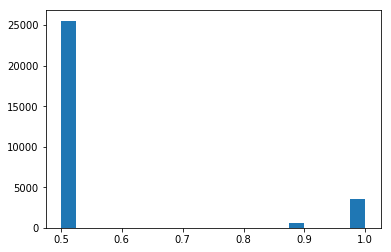

In [30]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

We can view the learned accuracy parameters as well.

In [31]:
gen_model.weights.lf_accuracy

array([0.98974954, 0.99064392, 0.98999589, 0.99055929, 0.99119495,
       0.99062531])

### Using the Model to Iterate on Labeling Functions

Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set. First, we apply the LFs to our development set:

In [32]:
L_dev = labeler.apply_existing(split=1)

[INFO] fonduer.utils.udf - Clearing existing...
[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=54), HTML(value='')))


[INFO] fonduer.utils.utils_annotations - Copying parttemp_label_updates to postgres
[INFO] fonduer.utils.utils_annotations - b'COPY 2697\n'


In [33]:
L_dev.shape

(2697, 6)

Then, we get the score of the generative model:

In [34]:
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
prec, rec, f1 = gen_model.score(L_dev, L_gold_dev)

We can also view statistics about the labeling function's learned accuracy and compare them to the emperical accuracy.

In [35]:
L_dev.lf_stats(L_gold_dev, gen_model.weights.lf_accuracy)

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_operating_row,0,0.008899,0.008899,0.0,24,0,0,0,1.000000,0.989750
LF_tstg_row,1,0.121987,0.121987,0.0,320,9,0,0,0.972644,0.990644
LF_negative_number_left,2,0.143122,0.142010,0.0,370,16,0,0,0.958549,0.989996
LF_to_left,3,0.107898,0.107898,0.0,288,3,0,0,0.989691,0.990559
LF_temperature_row,4,0.195773,0.136819,0.0,509,19,0,0,0.964015,0.991195
LF_storage_row,5,0.035224,0.035224,0.0,88,7,0,0,0.926316,0.990625


### Interpreting Generative Model Performance

At this point, we should be getting an F1 score of around 0.6 to 0.7 on the development set, which is pretty good! However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!

In fact, it is probably somewhat overfit to this set. However this is fine, since in the next, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a blind test set (i.e. one we never looked at during development).


### Training the Discriminative Model

Now, we'll use the noisy training labels we generated in the last part to train our end extraction model. For this tutorial, we will be training a simple--but fairly effective--logistic regression model.

We use the training marginals to train a discriminative model that classifies each Candidate as a true or false mention. 

In [36]:
from fonduer.learning import LogisticRegression

disc_model = LogisticRegression()
%time disc_model.train((train_cands, F_train), train_marginals, n_epochs=200, lr=0.001)

[INFO] fonduer.learning.disc_learning - Using CPU...
[INFO] fonduer.learning.disc_learning - Settings: {'input_dim': 22673, 'host_device': 'CPU'}
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Training model
[INFO] fonduer.learning.disc_learning - [LogisticRegression] n_train=4246  #epochs=200  batch size=256
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 1 (1.43s)	Average loss=0.344052
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 5 (7.04s)	Average loss=0.082700
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 10 (14.38s)	Average loss=0.073812
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 15 (21.69s)	Average loss=0.069793
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 20 (28.98s)	Average loss=0.067751
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 25 (36.08s)	Average loss=0.066416
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 30 (43

### Evaluating on the Test Set
In this final section, we'll get the score we've been after: the performance of the extraction model on the blind test set (split 2). First, we load the test set labels and gold candidates from earlier:

In [37]:
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

Now, we score using the discriminitive model:

In [38]:
import numpy as np

test_candidates = [F_test.get_candidate(session, i) for i in range(F_test.shape[0])]
test_score = disc_model.predictions((test_candidates, F_test))
true_pred = [test_candidates[_] for _ in np.nditer(np.where(test_score > 0))]

In [39]:
from hardware_utils import entity_level_f1
import os

import pickle
pickle_file = 'data/parts_by_doc_dict.pkl'
with open(pickle_file, 'rb') as f:
    parts_by_doc = pickle.load(f)

%time (TP, FP, FN) = entity_level_f1(true_pred, gold_file, ATTRIBUTE, test_docs, parts_by_doc=parts_by_doc)

Preparing candidates...


HBox(children=(IntProgress(value=0, max=1862), HTML(value='')))


Scoring on Entity-Level Gold Data
Corpus Precision 0.339
Corpus Recall    0.94
Corpus F1        0.498
----------------------------------------
TP: 78 | FP: 152 | FN: 5

CPU times: user 3.25 s, sys: 120 ms, total: 3.37 s
Wall time: 3.94 s


# Phase 4:  Error Analysis & Iterative KBC

During the development process, we can iteratively improve the quality of our labeling functions through error analysis, without executing the full pipeline as in previous techniques. 

You may have noticed that our final score is about 50 F1 points. To remedy this and improve our quality, we can perform error analysis to understand what kinds of patterns we may have missed, or what issues exist with our labeling functions. Then, we can edit our set of labeling functions and rerun Phase 3, Probabilistic Relation Classification. 

## Error Analysis
For example, notice that our `entity_level_f1` returns `TP`, `FP`, `FN` sets. We can also see that our recall is high, but we have low precision, so let's look at our false positivies, `FP`.

In [40]:
FP

[('BC546-D', 'BC546', '180'),
 ('BC546-D', 'BC546', '200'),
 ('BC546-D', 'BC546B', '180'),
 ('BC546-D', 'BC546B', '200'),
 ('BC546-D', 'BC546BG', '180'),
 ('BC546-D', 'BC546BG', '200'),
 ('BC546-D', 'BC546BRL1', '180'),
 ('BC546-D', 'BC546BRL1', '200'),
 ('BC546-D', 'BC546BRL1G', '180'),
 ('BC546-D', 'BC546BRL1G', '200'),
 ('BC546-D', 'BC546BZL1G', '180'),
 ('BC546-D', 'BC546BZL1G', '200'),
 ('BC546-D', 'BC547', '180'),
 ('BC546-D', 'BC547', '200'),
 ('BC546-D', 'BC547A', '180'),
 ('BC546-D', 'BC547A', '200'),
 ('BC546-D', 'BC547ARL', '180'),
 ('BC546-D', 'BC547ARL', '200'),
 ('BC546-D', 'BC547ARLG', '180'),
 ('BC546-D', 'BC547ARLG', '200'),
 ('BC546-D', 'BC547AZL1G', '180'),
 ('BC546-D', 'BC547AZL1G', '200'),
 ('BC546-D', 'BC547B', '180'),
 ('BC546-D', 'BC547B', '200'),
 ('BC546-D', 'BC547BG', '180'),
 ('BC546-D', 'BC547BG', '200'),
 ('BC546-D', 'BC547BRL1G', '180'),
 ('BC546-D', 'BC547BRL1G', '200'),
 ('BC546-D', 'BC547BZL1G', '180'),
 ('BC546-D', 'BC547BZL1G', '200'),
 ('BC546-D', '

We can see that there are actually only a few documents that are causing us problems. In particular, we see that `BC546-D` is giving us many false positives. So, let's inspect one of those candidates. 

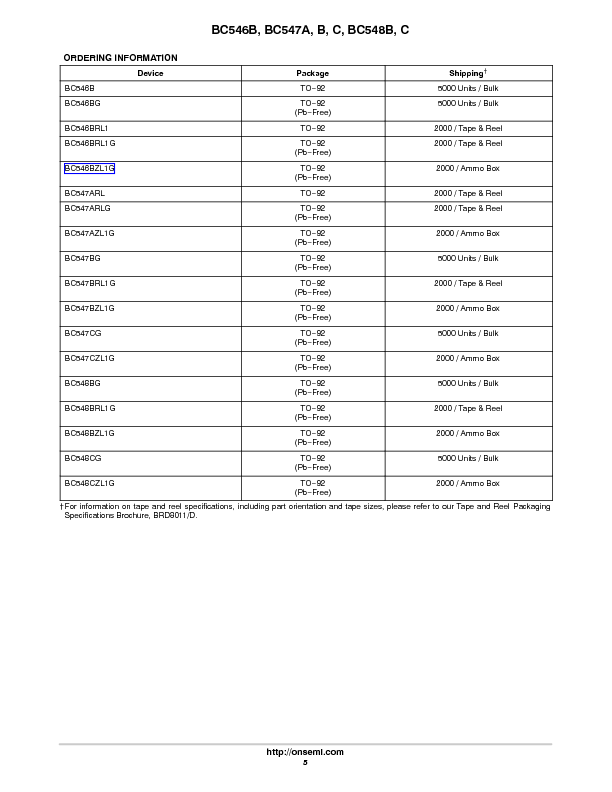

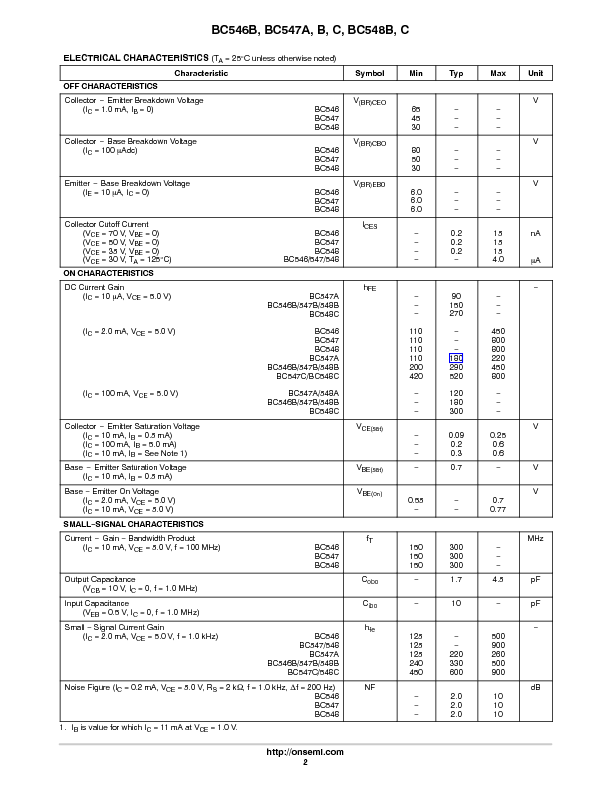

In [41]:
from fonduer.utils.visualizer import Visualizer
from hardware_utils import entity_to_candidates
vis = Visualizer(pdf_path)

# Get a list of candidates that match the FN[10] entity
test_cands = session.query(PartTemp).filter(PartTemp.split == 2).all()
fp_cands = entity_to_candidates(FP[10], test_cands)
# Display a candidate
vis.display_candidates([fp_cands[0]])

Here, the candidates are boxed in blue. We see that the temperature falls within the range of numbers that our matcher for storage temperature allows to match. By inspecting candidates like this, or just by examining the problematic PDFs directly, we can notice some patterns that we can exploit as new labeling functions.

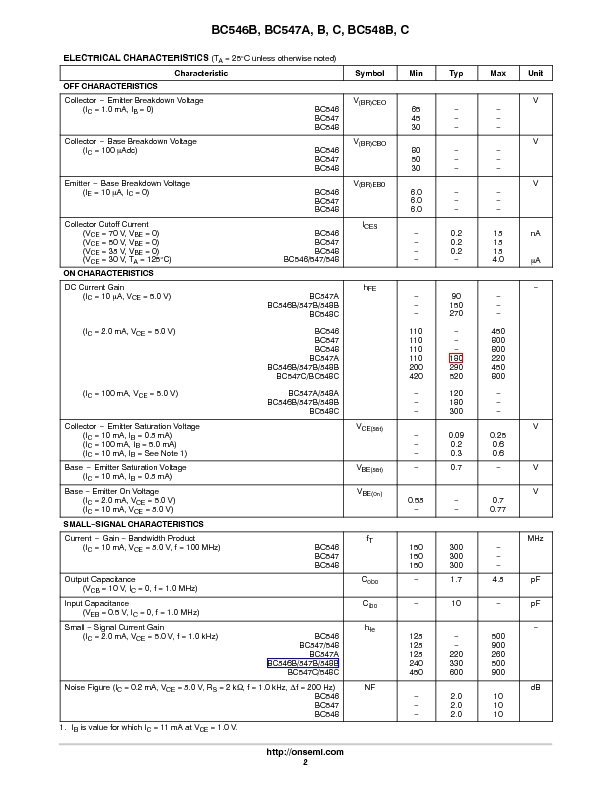

In [42]:
# Get a list of candidates that match the FN[10] entity
test_cands = session.query(PartTemp).filter(PartTemp.split == 2).all()
fp_cands = entity_to_candidates(FP[2], test_cands)

# # Display this candidate
vis.display_candidates([fp_cands[0]])

## Iteratively Improving Labeling Functions

From this error analysis, we may notice two important things. First, our original set of labeling functions had no labeling functions that labeled candidates a negative. This resulted in most skewing the models to accept most candidates, and hurt our precision. Second, we have now noticed that we need to focus on negatively labeling numbers that pass through our storage temperature matchers, but are not related to storage temperature.

Below are a set of negative labeling functions that capture some of these patterns. For example, we label candidates an negative if the number is aligned with attributes that are not related to storage temperature, if a candidate represents a typical value, rather than a maximum value, if a temperature value is found outside of a table, and other intuitive patterns we noticed when carefully inspecting our false positives.

In [43]:
from itertools import chain

def LF_test_condition_aligned(c):
    return -1 if overlap(
        ['test', 'condition'],
        list(get_aligned_ngrams(c.temp))) else 0

def LF_collector_aligned(c):
    return -1 if overlap(
        ['collector', 'collector-current', 'collector-base', 'collector-emitter'],
        list(get_aligned_ngrams(c.temp))) else 0

def LF_current_aligned(c):
    ngrams = get_aligned_ngrams(c.temp)
    return -1 if overlap(
        ['current', 'dc', 'ic'],
        list(get_aligned_ngrams(c.temp))) else 0

def LF_voltage_row_temp(c):
    ngrams = get_aligned_ngrams(c.temp)
    return -1 if overlap(
        ['voltage', 'cbo', 'ceo', 'ebo', 'v'],
        list(get_aligned_ngrams(c.temp))) else 0

def LF_voltage_row_part(c):
    ngrams = get_aligned_ngrams(c.part)
    return -1 if overlap(
        ['voltage', 'cbo', 'ceo', 'ebo', 'v'],
        list(get_aligned_ngrams(c.temp))) else 0

def LF_typ_row(c):
    return -1 if overlap(
        ['typ', 'typ.'],
        list(get_row_ngrams(c.temp))) else 0

def LF_complement_left_row(c):
    return -1 if (
        overlap(['complement','complementary'], 
        chain.from_iterable([get_row_ngrams(c.part), get_left_ngrams(c.part, window=10)]))) else 0


def LF_too_many_numbers_row(c):
    num_numbers = list(get_row_ngrams(c.temp, attrib="ner_tags")).count('number')
    return -1 if num_numbers >= 3 else 0

def LF_temp_on_high_page_num(c):
    return -1 if c.temp.span.get_attrib_tokens('page')[0] > 2 else 0

def LF_temp_outside_table(c):
    return -1 if not c.temp.span.sentence.is_tabular() is None else 0

def LF_not_temp_relevant(c):
    return -1 if not overlap(
        ['storage','temperature','tstg','stg', 'ts'],
        list(get_aligned_ngrams(c.temp))) else 0

Then, we can add these to our list of labeling functions

In [44]:
stg_temp_lfs_2 = [LF_test_condition_aligned,
                 LF_collector_aligned,
                 LF_current_aligned,
                 LF_voltage_row_temp,
                 LF_voltage_row_part,
                 LF_typ_row,
                 LF_complement_left_row,
                 LF_too_many_numbers_row,
                 LF_temp_on_high_page_num,
                 LF_temp_outside_table,
                 LF_not_temp_relevant
                ]

And rerun labeling. Importantly, this time we set `clear=False`, `update_keys=True` and `update_values=True` to reflect the fact that we are adding new labeling functions, but do not want to throw away the computations already performed in the previous iteration.

In [45]:
labeler = LabelAnnotator(PartTemp, lfs = stg_temp_lfs_2)
%time L_train = labeler.apply(split=0, clear=False, update_keys=True, update_values=True, parallelism=PARALLEL)
print(L_train.shape)

[INFO] fonduer.utils.udf - Running UDF...


HBox(children=(IntProgress(value=0, max=596), HTML(value='')))


[INFO] fonduer.utils.utils_annotations - Copying parttemp_label_updates to postgres
[INFO] fonduer.utils.utils_annotations - b'COPY 29789\n'
CPU times: user 4.16 s, sys: 636 ms, total: 4.8 s
Wall time: 8min 6s
(29789, 16)


Now, we can rerun probablistic relation classification, the same way we did above. We start with the generative model.

In [46]:
gen_model = GenerativeModel()
%time gen_model.train(L_train, epochs=500, decay=0.9, step_size=0.001/L_train.shape[0], reg_param=0)
train_marginals = gen_model.marginals(L_train)

[INFO] fonduer.learning.gen_learning - Inferred cardinality: 2
CPU times: user 14min 55s, sys: 64 ms, total: 14min 56s
Wall time: 14min 55s


Next, we rerun the discriminitive model and see that our score has improved significantly to about 80 F1 points.

In [47]:
disc_model = LogisticRegression()
%time disc_model.train((train_cands, F_train), train_marginals, n_epochs=200, lr=0.001)

[INFO] fonduer.learning.disc_learning - Using CPU...
[INFO] fonduer.learning.disc_learning - Settings: {'input_dim': 22673, 'host_device': 'CPU'}
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Training model
[INFO] fonduer.learning.disc_learning - [LogisticRegression] n_train=29789  #epochs=200  batch size=256
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 1 (10.53s)	Average loss=0.181916
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 5 (52.23s)	Average loss=0.055491
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 10 (102.17s)	Average loss=0.052573
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 15 (151.35s)	Average loss=0.051975
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 20 (200.52s)	Average loss=0.051643
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch 25 (250.39s)	Average loss=0.051432
[INFO] fonduer.learning.disc_learning - [LogisticRegression] Epoch

In [48]:
test_candidates = [F_test.get_candidate(session, i) for i in range(F_test.shape[0])]
test_score = disc_model.predictions((test_candidates, F_test))
true_pred = [test_candidates[_] for _ in np.nditer(np.where(test_score > 0))]
# tp, fp, tn, fn = disc_model.score(session, F_test, L_gold_test)
%time (TP, FP, FN) = entity_level_f1(true_pred, gold_file, ATTRIBUTE, test_docs, parts_by_doc=parts_by_doc)

Preparing candidates...


HBox(children=(IntProgress(value=0, max=274), HTML(value='')))


Scoring on Entity-Level Gold Data
Corpus Precision 0.874
Corpus Recall    0.916
Corpus F1        0.894
----------------------------------------
TP: 76 | FP: 11 | FN: 7

CPU times: user 120 ms, sys: 8 ms, total: 128 ms
Wall time: 127 ms


Using these new LFs, we've significantly improved precision and lowered our number of false positives for an F1 score of about 80.